In [53]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
import matplotlib 

from itertools import product

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

import h5py
from dustapprox.models import PrecomputedModel

import emcee
import corner

In [54]:
# ### Query Bayestar dustmap ###
# bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'

# bayestar = BayestarQuery(bayestar_path, version='bayestar2019')
# bayestar_dist = (bayestar.distances.to(u.pc)).value
# # distance = bayestar_dist[np.where(bayestar_dist < 1001)[0]]
distance = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 200)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

# reddening = 2.742 * bayestar(coords, mode='percentile', pct = (50, 16, 84)).astype(float) #Av, from https://iopscience.iop.org/article/10.1088/0004-637X/737/2/103#apj398709t6
# print(reddening.shape)

(200, 200, 200)


shape: (601, 601, 161)
(601, 601, 161)


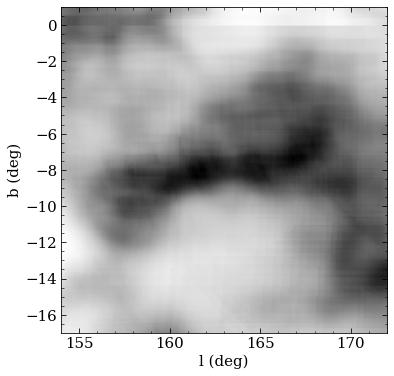

In [55]:
### Get Vergely+ (2022) dustmap for same points as Bayestar, now that it's in dustmaps
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox

vergelyquery = Vergely2022Query(map_fname = 
                                '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5')
vergely = vergelyquery(coords) * A0Coeff

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
plt.show()

In [56]:
lambda0 = 15272.42 
sigma0 = 1.37

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [57]:
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals'
respath  = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/'
CA_meta = Table(fits.open(CAresdir + 'CA_meta.fits')[1].data)

tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

stars_addon = stars['APOGEE_ID', 'SFD_EBV', 'SNR', 'ASPCAPFLAG', 'STARFLAG', 'ASPCAP_CHI2']
CA_meta['DIST'] = 1000 / CA_meta['GAIAEDR3_PARALLAX']

CA_meta = join(CA_meta, stars_addon, keys = 'APOGEE_ID', join_type = 'left',)

In [58]:
print(CA_meta.keys())

['APOGEE_ID', 'TELESCOPE', 'FIELD', 'RA', 'DEC', 'GLON', 'GLAT', 'J', 'H', 'K', 'AK_TARG', 'AK_WISE', 'VHELIO_AVG', 'GAIAEDR3_PARALLAX', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'ASPCAP_CHI2_1', 'MEDRES_NBIN', 'FILE', 'DIST', 'SFD_EBV', 'SNR', 'ASPCAPFLAG', 'STARFLAG', 'ASPCAP_CHI2_2']


In [59]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

for i in range(100):
    asdf = get_ca_res(CA_meta[i]['FILE'])
    try:
        fits.open(asdf)
    except:
        print('file doesnt exist')

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [60]:
b

array([[[-17.        , -17.        , -17.        , ..., -17.        ,
         -17.        , -17.        ],
        [-17.        , -17.        , -17.        , ..., -17.        ,
         -17.        , -17.        ],
        [-17.        , -17.        , -17.        , ..., -17.        ,
         -17.        , -17.        ],
        ...,
        [-17.        , -17.        , -17.        , ..., -17.        ,
         -17.        , -17.        ],
        [-17.        , -17.        , -17.        , ..., -17.        ,
         -17.        , -17.        ],
        [-17.        , -17.        , -17.        , ..., -17.        ,
         -17.        , -17.        ]],

       [[-16.90954774, -16.90954774, -16.90954774, ..., -16.90954774,
         -16.90954774, -16.90954774],
        [-16.90954774, -16.90954774, -16.90954774, ..., -16.90954774,
         -16.90954774, -16.90954774],
        [-16.90954774, -16.90954774, -16.90954774, ..., -16.90954774,
         -16.90954774, -16.90954774],
        ...,


In [61]:
l_cen, b_cen, = (163, -8.4)
s= select_stars(CA_meta, l_cen, b_cen, radius = .4)

In [62]:
def find_nearest(ll, bb):
    l_sel = l[0, :, 0]
    b_sel = b[:, 0,0]

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[l_ind, b_ind, :])

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[l_ind, b_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline))
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

# dAV_dd_star(l0, b0, (300, 480), CA_meta[sel1]['DIST'])


def Differential_Amplitude(dAv_dd, dd):
     return  0.027242739133535553 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd

    # dmin, dmax = bin_edges
    # dustmap_values = vergely()


In [63]:
### Get code to extract the necessary stellar residuals ###
dist_bins = np.array([np.nanmin(CA_meta['DIST']), np.nanmean(CA_meta['DIST']), np.nanmax(CA_meta['DIST'])])
dist_bins = np.array([np.nanmin(CA_meta['DIST']), np.nanmean(CA_meta['DIST']), np.nanmax(CA_meta['DIST'])])
print(dist_bins)

sel1 = np.where(CA_meta['DIST'][s] < dist_bins[1])[0]
sel2 = np.where(CA_meta['DIST'][s] > dist_bins[1])[0]

voxel_av1 = dAV_dd(l0, b0, tuple(dist_bins[0:2]))
voxel_av1_ = dAV_dd_star(l0, b0, tuple(dist_bins[0:2]), CA_meta[s][sel1]['DIST'])
voxel_amp1 = Differential_Amplitude(voxel_av1, 5 )
voxel_amp1_ = Differential_Amplitude(voxel_av1_, 5 )

voxel_av2 = dAV_dd(l0, b0, tuple(dist_bins[1:]))
voxel_av2_ = dAV_dd_star(l0, b0, tuple(dist_bins[1:]), CA_meta[s][sel2]['DIST'])
voxel_amp2 = Differential_Amplitude(voxel_av2, 5)
voxel_amp2_ = Differential_Amplitude(voxel_av2_, 5)

print(voxel_av1 * 5, voxel_av2 * 5)
print(voxel_amp1, voxel_amp2)

print(voxel_av1_ * 5, voxel_av2_ * 5)
print(voxel_amp1_, voxel_amp2_)

voxel_av0 = dAV_dd(l0, b0, (0, dist_bins[0])) # Av for pre-sample stars 
voxel_amp0 = Differential_Amplitude(voxel_av0, 5)
print('Before Cloud: ', voxel_av0, voxel_amp0)


print(len(sel1), len(sel2))

[-1553.2906    486.96716  1405.2418 ]
1.638916208390554 0.9425625161488429
0.04464856672690705 0.025677984744491816
1.3022870193970062 0.2649615667748415
0.035477865546422196 0.007218278844059869
Before Cloud:  0.0 0.0
12 6


In [64]:
voxel_dAv_dd = np.array([voxel_av0, voxel_av1, voxel_av2])
voxel_dAv_dd = np.array([voxel_av0, voxel_av1_, voxel_av2_])

voxel_dist = np.array([300, 486, 800])

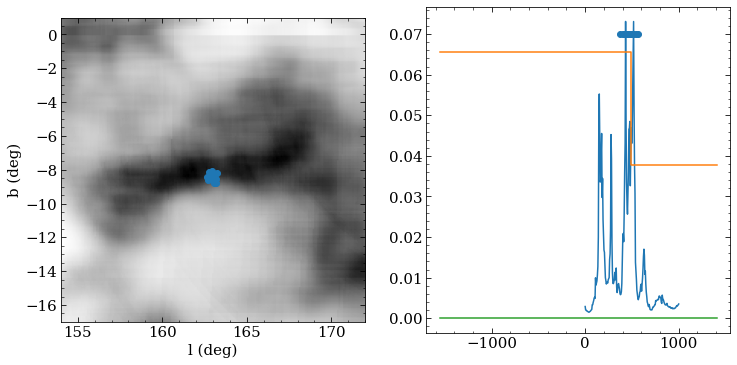

In [65]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
axs[0].imshow(np.sum(vergely * 5, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
axs[0].set_xlabel('l (deg)')
axs[0].set_ylabel('b (deg)')
axs[0].scatter(CA_meta['GLON'][s], CA_meta['GLAT'][s])

l_ind, b_ind = find_nearest(l0, b0)
axs[1].plot(distance, vergely[l_ind, b_ind, :] * 5)


norm_array = np.array([dist_bins[1]-dist_bins[0], dist_bins[1]-dist_bins[0], dist_bins[2] - dist_bins[1], dist_bins[2] - dist_bins[1]])
axs[1].plot([dist_bins[0], dist_bins[1], dist_bins[1], dist_bins[2]], np.array([voxel_av1, voxel_av1, voxel_av2, voxel_av2]) / 5)
axs[1].plot([dist_bins[0], dist_bins[1], dist_bins[1], dist_bins[2]], np.array([voxel_av1_, voxel_av1_, voxel_av2_, voxel_av2_]) / norm_array)

axs[1].scatter(CA_meta['DIST'][s], np.ones(len(CA_meta[s])) * 0.07)
plt.show()

In [66]:
def stack_DIBs(tab, return_unstacked = False):
    dib_array = np.zeros((len(tab), len(wavs_window)))
    for i in range(len(tab)):
        star = tab[i]

        try:
            res = fits.open(get_ca_res(star['FILE']))[1].data
            dib_array[i, :] = res[window]
        except:
            dib_array[i, :] = np.nan

    if return_unstacked:
        return np.nanmedian(dib_array, axis = 0), dib_array
    return np.nanmedian(dib_array, axis = 0)

dstack0 = stack_DIBs(CA_meta[CA_meta['DIST'] < 300])
dstack1 = stack_DIBs(CA_meta[s][sel1])
dstack2 = stack_DIBs(CA_meta[s][sel2])

In [67]:
signals = np.array([dstack0, dstack1, dstack2])

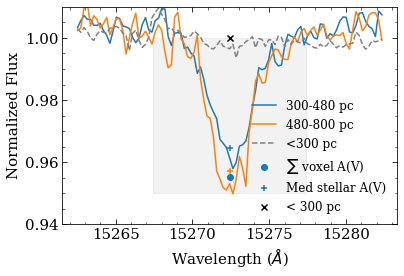

In [68]:
fig, ax = plt.subplots()
# for i in range(len(dstack)):
#     ax.plot(wavs_window, dstack1[i, :], linewidth = 1, color = 'grey', alpha = 0.5)

ax.plot(wavs_window, dstack1, label = '300-480 pc')
ax.plot(wavs_window, dstack2, label = '480-800 pc')

ax.plot(wavs_window, dstack0, label = '<300 pc', color = 'grey', linestyle = 'dashed')


ax.fill_between((lambda0-5, lambda0+5), (1, 1), (.95, .95), alpha = 0.1, color = 'grey')

ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1), label = '$\sum$ voxel A(V)', c = 'C0',)
ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1 + voxel_amp2), c = 'C1',)


ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1_), c = 'C0', marker = '+', label = 'Med stellar A(V)')
ax.scatter(lambda0, 1 - (voxel_amp0 + voxel_amp1_ + voxel_amp2_), marker = '+', c = 'C1')
ax.scatter(lambda0, 1 - (voxel_amp0), c = 'k', marker = 'x', label = '< 300 pc')


ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.legend(fontsize = 12)
ax.set_ylim(0.94, 1.01)
plt.show()

In [69]:
def make_signals(rvelo, m = 0, b = 1, dAv_dd = voxel_dAv_dd, dist = voxel_dist, **kwargs):
    signals = np.zeros((len(dist), len(wavs_window)))
    amp = Differential_Amplitude(dAv_dd, dd = 5) # CONVERT THIS

    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(dist), 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))

    def single_signal(dist_max, i, amp = amp, sigma0 = sigma0):
        # print(dist_max)
        amp = -amp.copy()
        amp[dist > dist_max] = 0
        voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        continuum = lambda x, m, b : m * (x - lambda0) + b
        cont = continuum(wavs_window, m, b)

        return summed_DIB  + cont
    

    for i in range(len(dist)):
        dist_max = dist[i]
        signals[i, :] = single_signal(dist_max, i)
    
    signals = signals #+ continuum(wavs_window, m, b)[np.newaxis, :]
    return signals


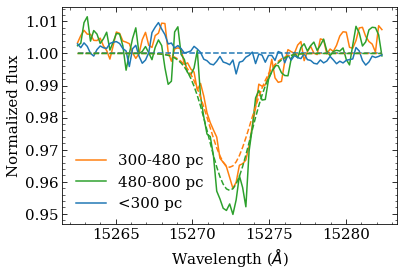

In [70]:
fig, ax = plt.subplots()

sig = make_signals(np.zeros(3))

ax.plot(wavs_window, dstack1, label = '300-480 pc', c = 'C1')
ax.plot(wavs_window, dstack2, label = '480-800 pc', color = 'C2')
ax.plot(wavs_window, dstack0, label = '<300 pc', color = 'C0')


for i in range(3):

    ax.plot(wavs_window, sig[i, :], c = 'C{}'.format(i), linestyle = 'dashed')


ax.legend()
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized flux' )

# ax.text(15262, 1.01, 'continuum = $-(1e-4) (\lambda - \lambda0) + 1.005$' , fontsize = 14)
plt.show()

In [71]:
SNR = 200
mm = 0
bb = 1

def loglikely(p, snr = SNR, signal = signals, **kwargs):
    v = p
    # m = p[:, 3] / 10
    # m = 0
    # b = p[:, 3] / 10
    # print(b)
    # b = 1
    return - 0.5 * np.sum((signal - make_signals(v, **kwargs))**2 / (1/snr**2)) 

def logprior(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        return -np.inf
    return 0.0

def logprob(v, logprior = logprior, loglikely = loglikely, **kwargs):
    lp = logprior(v, **kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikely(v, **kwargs)

In [72]:
nwalkers = 100
ndim = len(voxel_dist)
prior_mult = 4

sampler = emcee.EnsembleSampler(nwalkers, ndim , logprob, kwargs  = {'prior_mult':  prior_mult, 'v_max': 10, 'snr': SNR})
# init =  np.tile(voxel_rvelo, nwalkers).reshape((nwalkers, ndim)) + np.random.normal(0, 1/np.sqrt(SNR), (nwalkers, ndim))
init = 2 * prior_mult * 5 * (np.random.random((nwalkers, ndim)) - 0.5)
# init = np.hstack([init, 10 * np.ones(nwalkers).T[:, np.newaxis]])

In [73]:
steps = 500
sampler.run_mcmc(init,  steps);

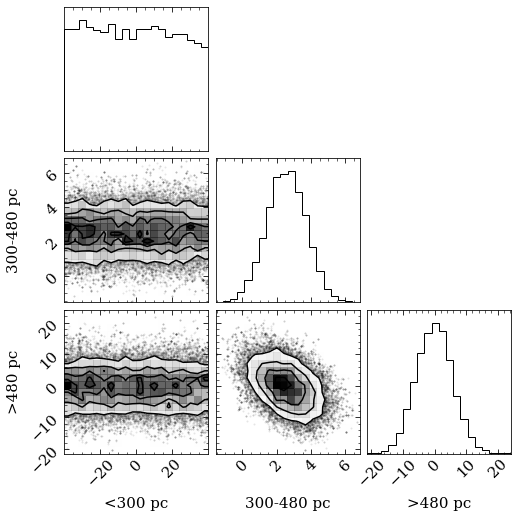

In [74]:
labels = ['{} pc'.format(i) for i in ['<300', '300-480', '>480']]
# print(labels)
samples = sampler.chain[:, 50:, :].reshape((-1, 3))
fig = corner.corner(samples, labels = labels, figsize = (20, 20))
# for ax in fig.axes:
    # ax.set_xlim(-10, 10)
    # ax.set_ylim(-20, 20) 
plt.show()

(500, 100)
5.7504381519467
-0.282153790464184
5.645901101293467


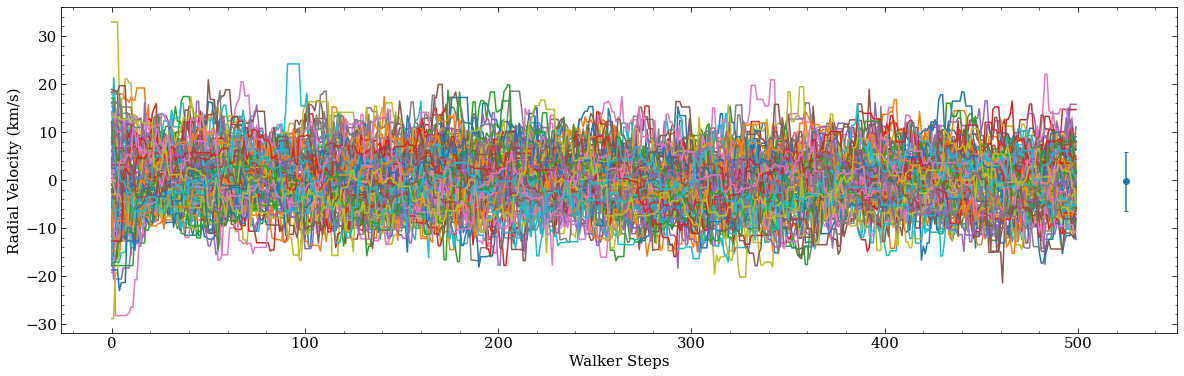

In [75]:
fig, ax = plt.subplots(figsize = (20, 6))

normalize = matplotlib.colors.Normalize(-10, 10)
cmap = matplotlib.cm.viridis
cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
colors = cmap(np.linspace(0,1,ndim))

# for i in range(ndim):
i = 2
walkers = sampler.chain[:,:,i].T
print(walkers.shape)
points = ax.plot(walkers)

cutoff = 100
median = np.median(walkers[100:, :])
perc16err =  median - np.percentile(walkers[100:, :], 16) 
perc84err =  np.percentile(walkers[100:, :], 84) - median
stdeviation =  np.std(walkers[100,:], ddof = 1)
print(perc16err)
print(median)
print(perc84err)


plt.errorbar(x = steps + 0.05 * steps, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

# fig.colorbar(cmappable, label = 'Velocity ')
ax.set_xlabel("Walker Steps")
ax.set_ylabel('Radial Velocity (km/s)')
plt.show()

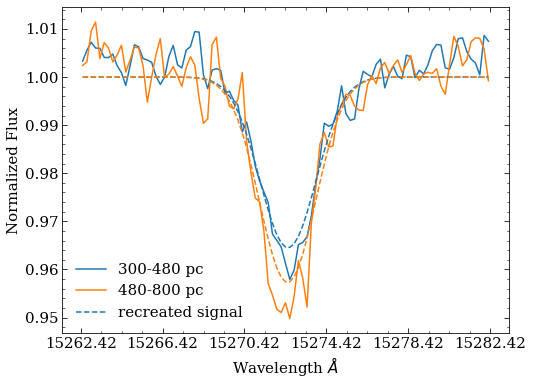

In [76]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(wavs_window, dstack1, label = '300-480 pc')
ax.plot(wavs_window, dstack2, label = '480-800 pc')

median_0 = np.nanmedian(samples[50:, 0])
median_1 = np.nanmedian(samples[50:, 1])
median_2 = np.nanmedian(samples[50:, 2])
std_1 = np.std(samples[50:, 1], ddof = 1)
std_2 = np.std(samples[50:, 2], ddof = 1)

signal_recreated = make_signals(np.array([median_0, median_1, median_2]))
ax.plot(wavs_window, signal_recreated[1, :], color = 'C0', linestyle = 'dashed', label = 'recreated signal')
ax.plot(wavs_window, signal_recreated[2, :], color = 'C1', linestyle = 'dashed')

ax.legend(loc = 'lower left')

ax.set_xlabel('Wavelength $\AA$')
ax.set_ylabel('Normalized Flux')
fig.set_facecolor('white')

ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))

plt.show()

<ErrorbarContainer object of 3 artists>

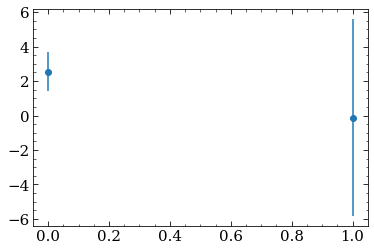

In [77]:
fig, ax = plt.subplots()
ax.scatter([0,1],[median_1, median_2])
ax.errorbar([0,1], [median_1, median_2], yerr = [std_1, std_2], fmt = '.')